In [11]:
# cd "C:\Users\leyla\OneDrive - Universitetet i Agder\Biomedical Signal\My_Project_MAS509"
# If pb with environment : Select interpeter (ctrl + shift + p), then kernel

In [3]:
import tensorflow as tf     #deep learning
import numpy as np          #Arrays & maths operations
import pandas as pd         # data handling (dataFrames)
import matplotlib.pyplot as plt      #ploting graphs
import seaborn as sns               # Statistical data visualization
from sklearn.preprocessing import StandardScaler    # Normalize features
from sklearn.model_selection import train_test_split    # split data train/test
from sklearn.metrics import classification_report, confusion_matrix     # model evaluation
import csv      # Read and write csv files

In [4]:
data_emg = pd.read_csv("C:/Users/leyla/OneDrive - Universitetet i Agder/Biomedical Signal/Olimex-EMG data acquisition/processed_data.csv", sep=";")
data_emg = np.array(data_emg)   #convert to NumPy array for processing
np.shape(data_emg)              # check shape: (rows, columns)

(400, 103)

In [5]:
# Separate labels (y) and features (x)
y = data_emg[:,[-1]].astype(int) # Extract last column as integers labels
x = data_emg[:, :-1]            # Extract all columns except the last as features
n_channel = 1               # Define nb channels (1 for EMG, 3 for accelerometer)
x = x.reshape(x.shape[0], x.shape[1], n_channel)    #reshape to 3d tensor for sequential models
np.shape(x)             # output shape (samples, time_steps, channels)

(400, 102, 1)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=100) #split data: 70% train 30% test
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((280, 102, 1), (280, 1), (120, 102, 1), (120, 1))

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)  #Normalize across last dimenstion (each feature independently)
# "Adapt" the normalizer on training data ONLY
normalizer.adapt(x_train)

# Define CNN (Convolutional Neural Network)
# shape expected = x_train.shape[1],1   # input shape to CNN model

num_class = 2
base_model = tf.keras.models.Sequential([
    normalizer,

    tf.keras.layers.Conv1D(filters=32, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
   
    tf.keras.layers.Conv1D(filters=64, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(filters=64, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(filters=64, kernel_size=3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(num_class, activation='softmax')

])


In [8]:
# Prepares the model for training
base_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Train with early stopping
# Stops training if the validation loss doesn't improve for a specified number of epochs (patience)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',             #Monitor validation loss during training
    patience=15,                    # Wait 15 epochs before stopping if no improvement
    restore_best_weights=True       # Restore the weight from the best epoch
)

history = base_model.fit(
    x_train,
    y_train,
    validation_split=0.2,           # Use 20% of training data for validation
    batch_size=32,                  # Nb of samples per training batch
    epochs=50,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(), early_stopping]      # Reduce learning rate if validation loss stagnates
                                                                            # Apply early stopping if needed
)

# SAVE
#base_model.save("My_final_ML3.keras")      #Creates a folder with model structure + weights + optimizer state

# Save weights only
#model.save_weights("my_weights.h5")

base_model.summary()    # model summary

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5179 - loss: 2.2711 - val_accuracy: 0.4821 - val_loss: 2.1628 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6518 - loss: 2.0040 - val_accuracy: 0.7321 - val_loss: 1.9305 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7991 - loss: 1.7717 - val_accuracy: 0.7143 - val_loss: 1.7529 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8125 - loss: 1.5736 - val_accuracy: 0.6786 - val_loss: 1.5861 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7723 - loss: 1.3884 - val_accuracy: 0.6964 - val_loss: 1.3920 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8571 - loss: 1.2081 - val_accuracy: 0.7321 - val_loss: 1.2798 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8304 - loss: 1.0299 - val_accuracy: 0.7857 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (32, 102, 1)           │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (32, 100, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 100, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (32, 50, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (32, 48, 64)           │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (32, 48, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (32, 24, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (32, 22, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (32, 22, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (32, 11, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (32, 9, 64)            │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (32, 9, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (32, 4, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,587 (752.30 KB)

 Trainable params: 64,194 (250.76 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 128,390 (501.53 KB)

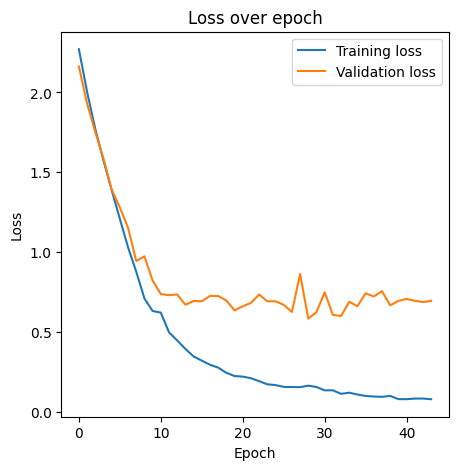

[2.2710530757904053, 2.0040299892425537, 1.7716952562332153, 1.5735704898834229, 1.3884483575820923, 1.2081031799316406, 1.0298930406570435, 0.8768061995506287, 0.7095609307289124, 0.6307188868522644, 0.6204877495765686, 0.49713417887687683, 0.4461830258369446, 0.3929404616355896, 0.34598883986473083, 0.3196468949317932, 0.29405683279037476, 0.27589353919029236, 0.24340656399726868, 0.2231374830007553, 0.21958351135253906, 0.20962531864643097, 0.19093023240566254, 0.1714855283498764, 0.16654904186725616, 0.15516935288906097, 0.1541585773229599, 0.15358372032642365, 0.16295109689235687, 0.15466976165771484, 0.1336824744939804, 0.13364659249782562, 0.1119048222899437, 0.11863863468170166, 0.10748966783285141, 0.09854613989591599, 0.0947374626994133, 0.09298170357942581, 0.09873976558446884, 0.07865554839372635, 0.07804940640926361, 0.08206798881292343, 0.08220995962619781, 0.07790692895650864]
[2.16275954246521, 1.9304848909378052, 1.752867341041565, 1.58608078956604, 1.3920269012451172,

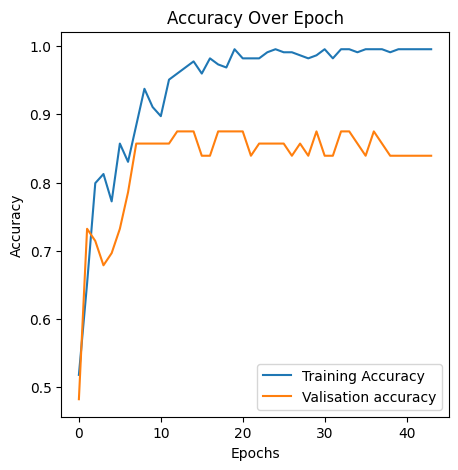

In [9]:
plt.figure(figsize=(5,5))

# Use the actual number of epochs from history
num_epochs = len(history.history['loss'])
plt.plot(range(num_epochs), history.history['loss'], label='Training loss')
plt.plot(range(num_epochs), history.history['val_loss'], label='Validation loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epoch")
plt.show()
print(history.history['loss'])
print(history.history['val_loss'])

plt.figure(figsize=(5, 5))
plt.plot(range(num_epochs), history.history['accuracy'], label="Training Accuracy")
plt.plot(range(num_epochs), history.history['val_accuracy'], label="Valisation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epoch")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9333 - loss: 0.3342
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


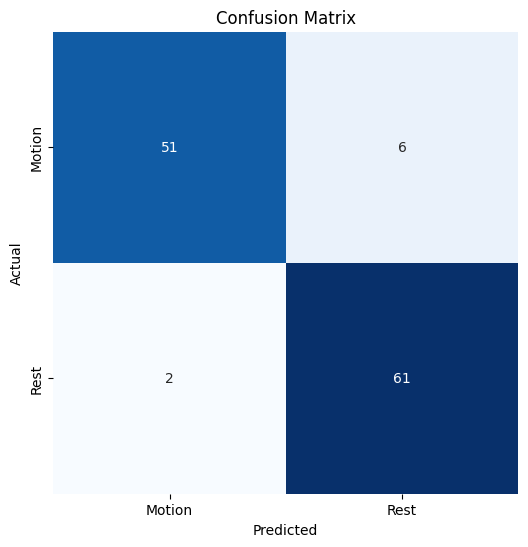

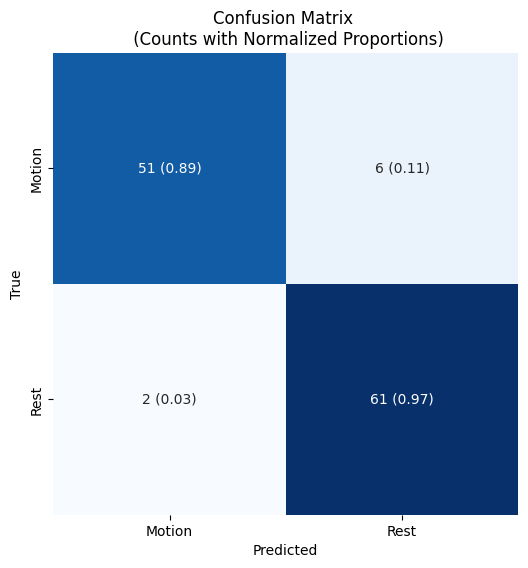

              precision    recall  f1-score   support

           0       0.96      0.89      0.93        57
           1       0.91      0.97      0.94        63

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120



In [10]:
# LOAD
# loaded_model = tf.keras.models.load_model("model_emg_project")

base_model.evaluate(x_test, y_test)         # evaluate on test data set
y_true = np.array(y_test)                   # ground truth label
y_pred = np.array(list(map(lambda x: np.argmax(x), base_model.predict(x_test))))     # predicted label

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Row-wise normalization (axis=1) shows recall / sensitivity per class
# col wise normalization (axis=0) shows precision

class_names = ['Motion', 'Rest']
# sns.heatmap(..., xticklabels=class_names, ytick_labels=class_names)   # pour afficher les noms des classes

plt.figure(figsize=(6,6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='g', 
    cmap='Blues', 
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print normalized and unnormalized value
annot = np.array([
    [f"{cm[i,j]} ({cm_normalized[i,j]:.2f})"
     for j in range(cm.shape[1])]
     for i in range(cm.shape[0])
])

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=annot,        # Combined values
    fmt='',             # Disable default formatting
    cmap="Blues",
    cbar=False,
    linewidths=0.8,
    linecolor='none',
    annot_kws={"size": 10},     # Adjust font size
    xticklabels=class_names, yticklabels=class_names
)

plt.title("Confusion Matrix \n (Counts with Normalized Proportions)")
plt.xlabel("Predicted")
plt.ylabel('True')
plt.show()


print(classification_report(y_true, y_pred))

